<a href="https://colab.research.google.com/github/BurhanAmir/Machine-Learning-Project/blob/main/imb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Setup | Importing necessary Libraries\**

In [1]:
# Cell 0 — Install dependencies (Colab)
# Run once at the top. Comment out installs if already available locally.
!pip install -q imbalanced-learn xgboost shap plotly==5.6.0

# Optional: fix numpy/scipy warnings in some environments
import warnings
warnings.filterwarnings('ignore')


# Cell 1 — imports and global configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gdown
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve, brier_score_loss)
from sklearn.calibration import calibration_curve

# Optional: for hyperparameter search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# SHAP (for explainability)
import shap

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plot style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 84.6 MB/s eta 0:00:00


**Mounting Drive\**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing dataset through drive.\**

In [3]:
# Install gdown if needed
!pip install --quiet gdown

# Import gdown after installation
import gdown

# File ID from the shared link
dataset_id = "1j8dxLoIHIel8J8DY36xUyT-BO37-zvZo"
url = f"https://drive.google.com/uc?id={dataset_id}"
output = "dataset.csv"

# Download only if not already downloaded
if not os.path.exists(output):
    print("⏬ Downloading dataset from Google Drive …")
    gdown.download(url, output, quiet=False)
else:
    print("✅ Dataset already exists locally – skipping download.")

# Load into pandas DataFrame
df = pd.read_csv(output)

# Quick check
print("✅ Dataset loaded. Here are first few rows:")
print(df.head())

⏬ Downloading dataset from Google Drive …


Downloading...
From: https://drive.google.com/uc?id=1j8dxLoIHIel8J8DY36xUyT-BO37-zvZo
To: /content/dataset.csv
100%|██████████| 978k/978k [00:00<00:00, 39.3MB/s]


✅ Dataset loaded. Here are first few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

**Few enteries of the datset.\**

In [4]:
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**All of the unique values of the variables (dataset columns).**

In [5]:
for i in df.columns:
    print(f"{i}: {df[i].unique()}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

**General insights about data.\**     EDA (Explorartory Data Analysis)

In [6]:
# Quick info
print(df.shape)
print(df.columns.tolist())
df.info()
df.describe(include='all').T


(7043, 21)
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   ob

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Data Manipulation and Cleaning**

In [7]:
# Cell 3 — common fixes (Telco-style dataset)
# Convert TotalCharges to numeric (if applicable)
if 'TotalCharges' in df.columns:
    # detect non-numeric values
    non_numeric = df['TotalCharges'].apply(lambda x: isinstance(x, str) and x.strip()=='' )
    print("Empty-string TotalCharges rows:", non_numeric.sum())
    # coerce to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print("TotalCharges nulls after coercion:", df['TotalCharges'].isna().sum())

# Count missing values
mv = df.isna().sum()
display(mv[mv>0])



Empty-string TotalCharges rows: 11
TotalCharges nulls after coercion: 11


,0
TotalCharges,11


Target distribution:


,proportion
Churn,
No,0.73463
Yes,0.26537


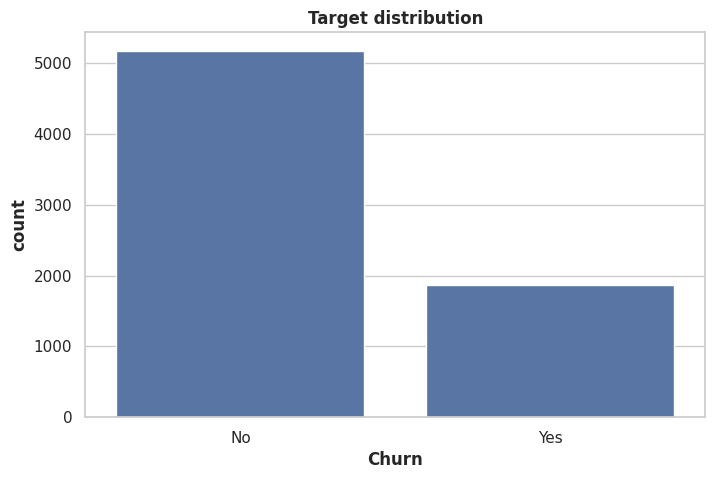

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


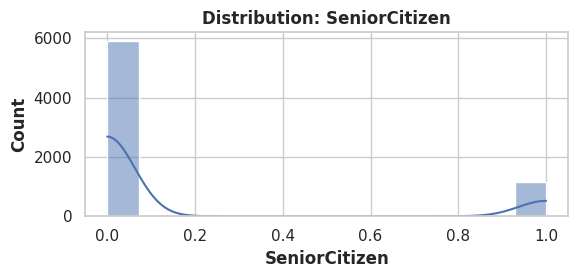

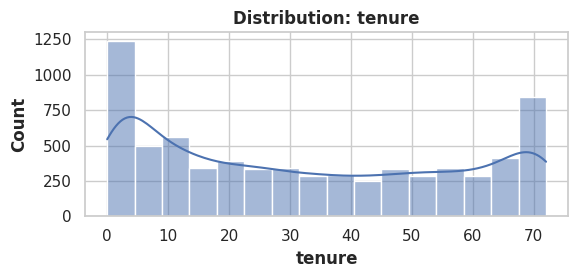

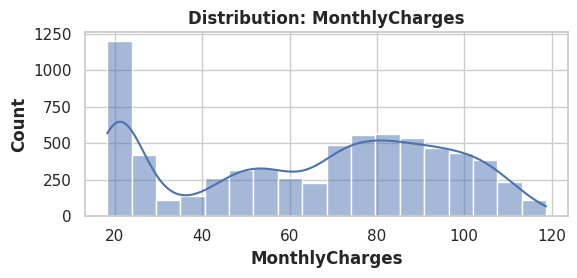

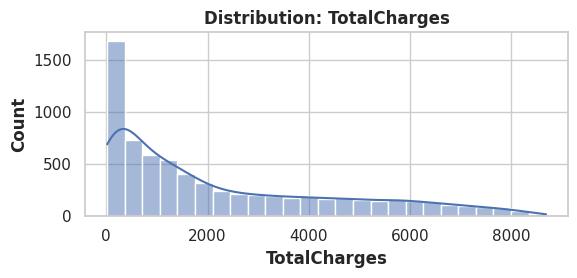

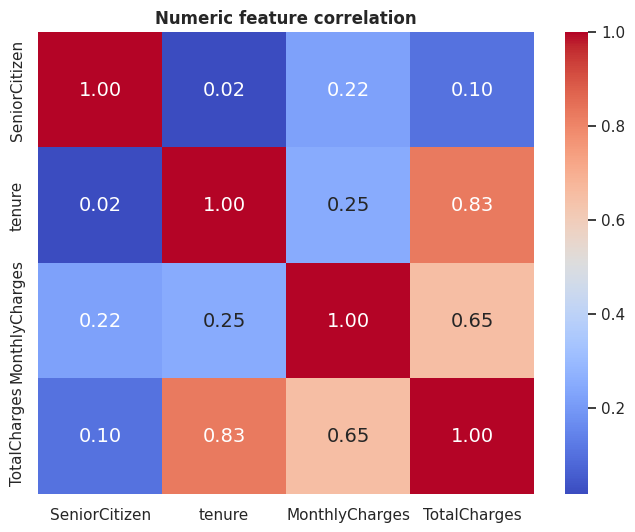

Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


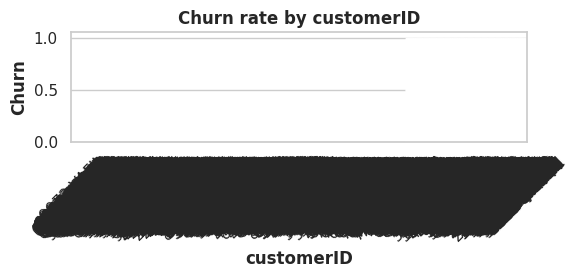

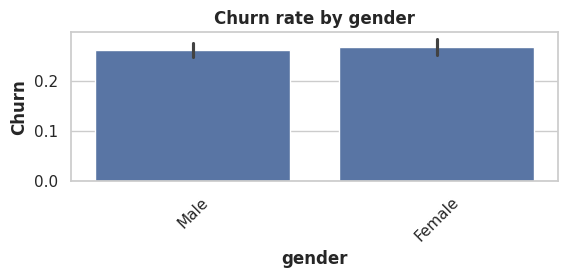

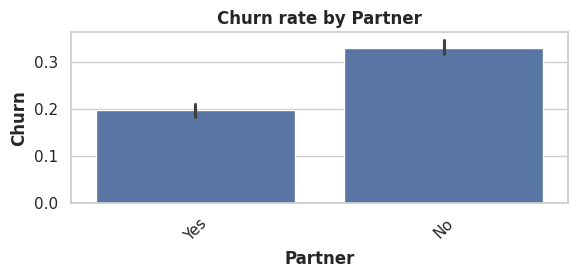

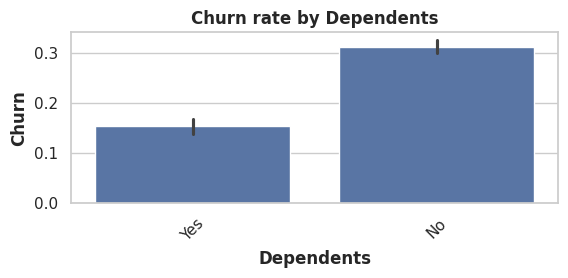

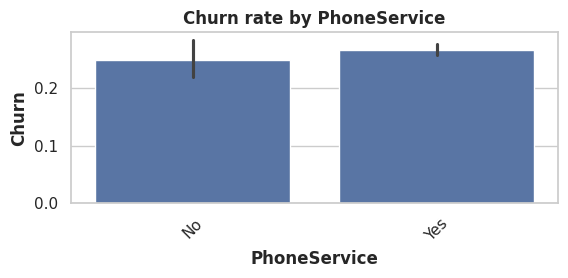

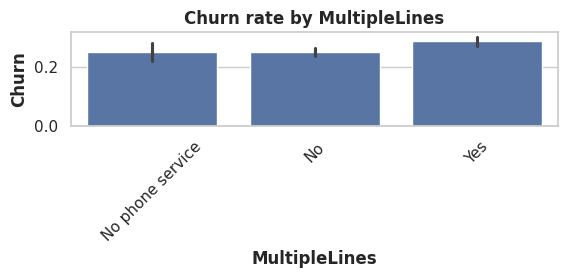

In [8]:
# Cell 4 — EDA: target distribution and key plots
TARGET = 'Churn'  # adjust if different

# Define OUTPUT_DIR and create it if it doesn't exist
OUTPUT_DIR = '/content/output_plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Target distribution:")
display(df[TARGET].value_counts(normalize=True).rename('proportion'))

# Plot class distribution
sns.countplot(x=TARGET, data=df)
plt.title('Target distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'target_distribution.png'))
plt.show()

# Numeric distributions
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numeric columns:", numeric_cols)
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution: {col}')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'dist_{col}.png'))
    plt.show()

# Correlation heatmap (numeric)
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Numeric feature correlation')
    plt.savefig(os.path.join(OUTPUT_DIR, 'corr_heatmap.png'))
    plt.show()

# Target vs categorical top features (example)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != TARGET]
print("Categorical columns:", cat_cols)
for c in cat_cols[:6]:  # show first 6 for speed; expand as needed
    plt.figure(figsize=(6,3))
    order = df.groupby(c)[TARGET].apply(lambda x: (x=='Yes').mean()).sort_values().index
    sns.barplot(x=c, y=df[TARGET].apply(lambda x: 1 if x=='Yes' else 0), estimator=np.mean, order=order, data=df)
    plt.xticks(rotation=45)
    plt.title(f'Churn rate by {c}')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'churn_by_{c}.png'))
    plt.show()

**Converting the target label into binary**

In [9]:
# Cell 5 — Preprocessing pipeline setup
# Identify feature sets
target = TARGET
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if str(x).strip().lower() in ['yes','1','true','y'] else 0)

# Simple heuristic to separate numeric & categorical
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features[:20])

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Removed sparse=False
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [10]:
# Cell 6 — Model definitions and CV evaluation
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1),
    'SVC': SVC(probability=True, random_state=RANDOM_SEED)
}

def evaluate_models_cv(X, y, preprocessor, models, cv_splits=5):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_SEED)
    results = {}
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for name, clf in models.items():
        pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', clf)])
        scores = cross_validate(pipe, X, y, cv=skf, scoring=scoring, return_train_score=False, n_jobs=-1)
        summary = {metric: (np.mean(scores[f'test_{metric}']), np.std(scores[f'test_{metric}'])) for metric in scoring}
        results[name] = summary
        print(f"=== {name} ===")
        for m,(mu,std) in summary.items():
            print(f"{m}: {mu:.4f} ± {std:.4f}")
        print()
    return results

cv_results = evaluate_models_cv(X, y, preprocessor, models, cv_splits=5)


=== LogisticRegression ===
accuracy: 0.8058 ± 0.0123
precision: 0.6593 ± 0.0246
recall: 0.5532 ± 0.0340
f1: 0.6015 ± 0.0300
roc_auc: 0.8449 ± 0.0134

=== RandomForest ===
accuracy: 0.7903 ± 0.0116
precision: 0.6486 ± 0.0300
recall: 0.4569 ± 0.0299
f1: 0.5360 ± 0.0298
roc_auc: 0.8267 ± 0.0161

=== SVC ===
accuracy: 0.8009 ± 0.0150
precision: 0.6722 ± 0.0409
recall: 0.4879 ± 0.0373
f1: 0.5650 ± 0.0367
roc_auc: 0.8067 ± 0.0197



**Pre-processing the dataset**

Test set metrics:
Accuracy: 0.7927117841930904
Precision: 0.6518518518518519
Recall: 0.47058823529411764
F1: 0.546583850931677
ROC-AUC: 0.8264156881121708

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.65      0.47      0.55       561

    accuracy                           0.79      2113
   macro avg       0.74      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



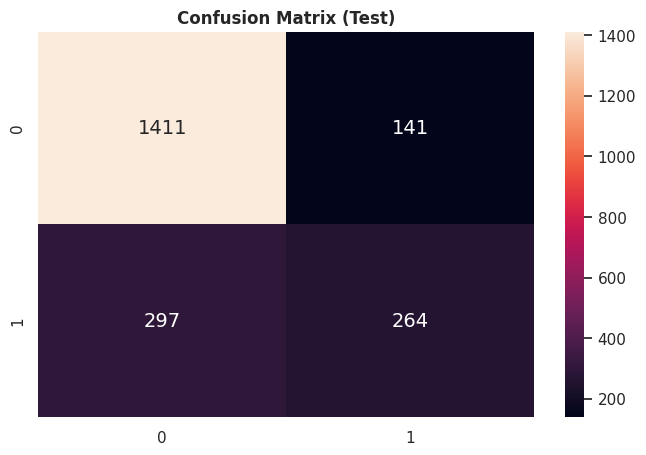

In [11]:
# Cell 7 — Train/test split + final evaluation for chosen model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_SEED)

# Choose best model from cv_results manually (example: RandomForest)
best_clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
full_pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', best_clf)])
full_pipe.fit(X_train, y_train)

# Predictions & metrics
y_pred = full_pipe.predict(X_test)
y_proba = full_pipe.predict_proba(X_test)[:,1]

print("Test set metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_test.png'))
plt.show()


In [12]:
# Cell 8 — Experiment: SMOTE in pipeline vs class_weight
from imblearn.over_sampling import SMOTE

# 1) Using class_weight for RandomForest
rf_cw = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_SEED, n_jobs=-1)
pipe_cw = Pipeline(steps=[('preproc', preprocessor), ('clf', rf_cw)])

# 2) Using SMOTE + RandomForest in imbalanced pipeline
smote = SMOTE(random_state=RANDOM_SEED)
imb_pipe = ImbPipeline(steps=[('preproc', preprocessor), ('smote', smote), ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring = ['precision', 'recall', 'f1', 'roc_auc']

for name, p in [('ClassWeight_RF', pipe_cw), ('SMOTE+RF', imb_pipe)]:
    scores = cross_validate(p, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    print(f"=== {name} ===")
    for metric in scoring:
        mu, sd = np.mean(scores[f'test_{metric}']), np.std(scores[f'test_{metric}'])
        print(f"{metric}: {mu:.4f} ± {sd:.4f}")
    print()


=== ClassWeight_RF ===
precision: 0.6406 ± 0.0254
recall: 0.4783 ± 0.0332
f1: 0.5475 ± 0.0307
roc_auc: 0.8300 ± 0.0151

=== SMOTE+RF ===
precision: 0.6136 ± 0.0167
recall: 0.5361 ± 0.0396
f1: 0.5719 ± 0.0296
roc_auc: 0.8280 ± 0.0144



**Assigning the datatypes to the variables, so they can be trained and processed**

In [13]:
# Cell 9 — Hyperparameter tuning for RandomForest (randomized search)
param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 10, 20, 40],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4],
    'clf__class_weight': [None, 'balanced']
}

pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1))])
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=20, cv=skf, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_SEED, verbose=1)
search.fit(X, y)

print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)
best_model = search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 40, 'clf__class_weight': 'balanced'}
Best CV ROC-AUC: 0.83654608568777


Total features after preproc: 7088


,0
tenure,0.080930
TotalCharges,0.075276
MonthlyCharges,0.059872
Contract_Month-to-month,0.046788
Contract_Two year,0.030910
TechSupport_No,0.027858
OnlineSecurity_No,0.025395
InternetService_Fiber optic,0.025144
PaymentMethod_Electronic check,0.023190
Contract_One year,0.018141


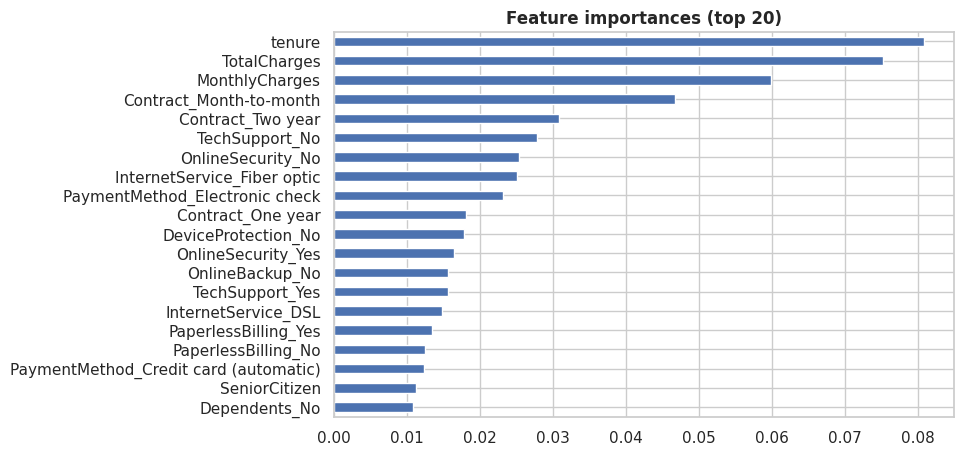

SHAP failed: Cannot cast ufunc 'isnan' input from dtype('O') to dtype('bool') with casting rule 'same_kind'
If SHAP fails in Colab, consider installing a compatible shap version and rerunning.


In [14]:
# Cell 10 — Feature importance + SHAP explanation
# Get preprocessed feature names
preproc = best_model.named_steps['preproc'] if 'best_model' in globals() else full_pipe.named_steps['preproc']
# Build feature names for onehot-encoded features
ohe = None
for name, trans, cols in preproc.transformers_:
    if name == 'cat':
        ohe = trans.named_steps['onehot']
        cat_cols = cols
    if name == 'num':
        num_cols = cols

# numeric names
feat_names = list(num_cols)
if ohe is not None:
    # get feature names from onehot
    ohe_feats = ohe.get_feature_names_out(cat_cols)
    feat_names += list(ohe_feats)

print("Total features after preproc:", len(feat_names))

# If model has feature_importances_ (RandomForest), show top features
clf = best_model.named_steps['clf'] if 'best_model' in globals() else full_pipe.named_steps['clf']
if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
    display(fi.head(20))
    fi.head(20).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title('Feature importances (top 20)')
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importances.png'))
    plt.show()

# SHAP (kernel or TreeExplainer depending on model)
# For tree model
try:
    # create explainer using the preprocessed training sample
    X_pre = preproc.transform(X_train)  # numpy array
    if clf.__class__.__name__ in ['RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier', 'GradientBoostingClassifier']:
        explainer = shap.TreeExplainer(clf)
    else:
        explainer = shap.KernelExplainer(clf.predict_proba, shap.sample(X_pre, 100))
    shap_values = explainer.shap_values(X_pre[:200])  # limit to first 200 for speed

    # plot summary
    shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values, X_pre[:200], feature_names=feat_names, show=True)
except Exception as e:
    print("SHAP failed:", e)
    print("If SHAP fails in Colab, consider installing a compatible shap version and rerunning.")


**Mapping the values to numerical format. Here 1 represent yes and 0 represent no.**

Brier score: 0.1434607785139612


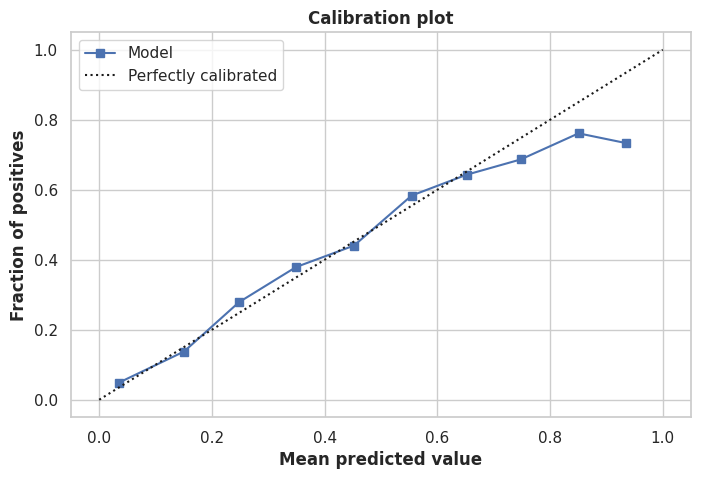

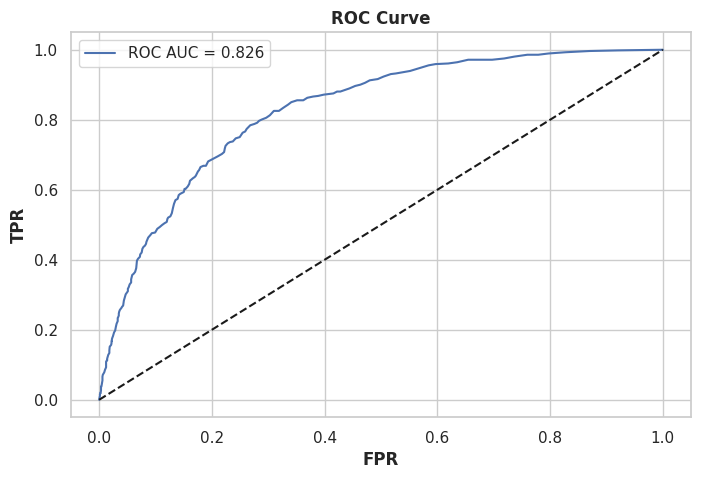

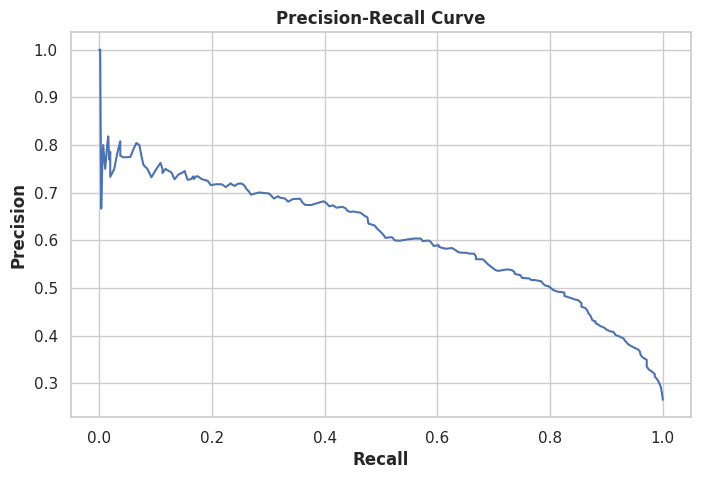

In [15]:
# Cell 11 — Calibration curve and Brier score on test set
prob_pos = full_pipe.predict_proba(X_test)[:,1]
brier = brier_score_loss(y_test, prob_pos)
print("Brier score:", brier)

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Model')
plt.plot([0,1], [0,1], "k:", label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'calibration_curve.png'))
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, prob_pos)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, prob_pos):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, prob_pos)
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig(os.path.join(OUTPUT_DIR, 'pr_curve.png'))
plt.show()


**EDA (Explorartory Data Analysis) with Visual Plots **

In [16]:
# Cell 12 — Save best model and metadata
model_path = os.path.join(OUTPUT_DIR, 'best_model.joblib')
joblib.dump(full_pipe, model_path)
print("Saved model to:", model_path)

# Save CV results to CSV for report
import json, csv
cv_summary_file = os.path.join(OUTPUT_DIR, 'cv_summary.json')
with open(cv_summary_file, 'w') as f:
    json.dump({k: {m: [float(v[0]), float(v[1])] for m, v in vdict.items()} for k,vdict in cv_results.items()}, f, indent=2)
print("Saved CV summary to:", cv_summary_file)


Saved model to: /content/output_plots/best_model.joblib
Saved CV summary to: /content/output_plots/cv_summary.json


In [17]:
# Cell 13 — save requirements and environment info
!pip freeze > /content/requirements.txt
print("Saved pip packages list to /content/requirements.txt")
!python -V
import sys
print("Python executable:", sys.executable)


Saved pip packages list to /content/requirements.txt
Python 3.12.12
Python executable: /usr/bin/python3


**Train and Split Dataset 70% for training, 30% for testing**

**Pre-processing (pipeline) + Logistic Regression**

**Prediction**